In [3]:

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda




################################################################
def multi_unet_model(n_classes=3, IMG_HEIGHT=512, IMG_WIDTH=512, IMG_CHANNELS=3):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.summary()
    
    return model

In [4]:
import tensorflow as tf
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [ ]:

#Resizing images, if needed
SIZE_X = 256
SIZE_Y = 256
n_classes=3 #Number of classes for segmentation

#Capture training image info as a list
train_images_campo = []
train_images_synt = []
train_images_text = []

images_name_train = []

for directory_path in glob.glob("/content/drive/MyDrive/Projetos/Rachadura_Eucalipto/Analise rachadura/CNN/Syntetic_images/Images"):
    for img_path in sorted(glob.glob(os.path.join(directory_path, "*.png"))):
        images_name_train.append(img_path.split('/')[-1])
        img = cv2.imread(img_path)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        name = img_path.split('/')[-1]
        if name[:3] == 'SYN':
          train_images_synt.append(img)
        elif name[:3] == 'TEX':
          train_images_text.append(img)
        else:
          train_images_campo.append(img)
       
#Convert list to array for machine learning processing        
train_images_campo = np.array(train_images_campo)
train_images_synt = np.array(train_images_synt)
train_images_text = np.array(train_images_text)

#Capture mask/label info as a list
train_masks_campo = []
train_masks_synt = []
train_masks_text = []

image_name_mask = []

for directory_path in glob.glob('/content/drive/MyDrive/Projetos/Rachadura_Eucalipto/Analise rachadura/CNN/Syntetic_images/Masks'):
    for mask_path in sorted(glob.glob(os.path.join(directory_path, "*.png"))):
        image_name_mask.append(mask_path.split('/')[-1])
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        name = mask_path.split('/')[-1]
        if name[:3] == 'SYN':
          train_masks_synt.append(mask)
        elif name[:3] == 'TEX':
          train_masks_text.append(mask)
        else:
          train_masks_campo.append(mask)
     
#Convert list to array for machine learning processing          
train_masks_campo = np.array(train_masks_campo)
train_masks_synt = np.array(train_masks_synt)
train_masks_text = np.array(train_masks_text)


In [ ]:
#Data augmentation
import albumentations as A

IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS = 256,256,3

aug = A.Compose([A.RandomBrightnessContrast(p=0.8), 
                 A.VerticalFlip(p=0.7),
                 A.HorizontalFlip(p=0.7),
                 A.RandomGamma(p=0.8)])

train_images_aug = np.empty(shape=(0,256,256,3),dtype='uint8')
train_masks_aug = np.empty(shape=(0,256,256),dtype='uint8')

for x,y in zip([train_images_campo,train_images_text],[train_masks_campo,train_masks_text]):
  for _ in range(2):
    augmented = aug(image=x, mask=y)
    train_images_aug = np.concatenate([train_images_aug,augmented['image']])
    train_masks_aug = np.concatenate([train_masks_aug,augmented['mask']])


In [ ]:
#train_images = np.expand_dims(train_images, axis=3)
train_images_campo_normal = tf.keras.utils.normalize(train_images_campo, axis=1)
train_images_synt_normal = tf.keras.utils.normalize(train_images_synt, axis=1)
train_images_text_normal = tf.keras.utils.normalize(train_images_text, axis=1)
train_images_aug_normal = tf.keras.utils.normalize(train_images_aug, axis=1)

train_masks_input_campo = np.expand_dims(train_masks_campo, axis=3)
train_masks_input_synt = np.expand_dims(train_masks_synt, axis=3)
train_masks_input_text = np.expand_dims(train_masks_text, axis=3)
train_masks_input_aug = np.expand_dims(train_masks_aug, axis=3)

#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split

X_train_campo, X_test_campo, y_train_campo,y_test_campo = train_test_split(train_images_campo_normal, train_masks_input_campo,test_size = 0.20, random_state = 42,shuffle=True)
X_train_synt, X_test_synt, y_train_synt, y_test_synt = train_test_split(train_images_synt_normal, train_masks_input_synt,test_size = 0.20, random_state = 42,shuffle=True)
X_train_text, X_test_text, y_train_text, y_test_text = train_test_split(train_images_text_normal, train_masks_input_text,test_size = 0.20, random_state = 42,shuffle=True)
X_train_aug, X_test_aug, y_train_aug, y_test_aug = train_test_split(train_images_aug_normal, train_masks_input_aug,test_size = 0.20, random_state = 42,shuffle=True)


X_train = np.concatenate([X_train_campo,X_train_synt,X_train_text,X_train_aug],axis=0)
y_train = np.concatenate([y_train_campo,y_train_synt,y_train_text,y_train_aug],axis=0)
X_test = np.concatenate([X_test_campo,X_test_synt,X_test_text,X_test_aug],axis=0)
y_test = np.concatenate([y_test_campo,y_test_synt,y_test_text,y_test_aug],axis=0)

#Further split training data t a smaller subset for quick testing of models
#X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.1, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 


Class values in the dataset are ...  [0 1 2]


In [ ]:
train_masks_cat = tf.keras.utils.to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))



test_masks_cat =  tf.keras.utils.to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight = "balanced", classes = np.unique(y_train),y = np.array(y_train.reshape(-1)))
class_weights = {i : class_weights[i] for i in range(3)}
class_weights

{0: 0.528230794382219, 1: 0.9398399041492138, 2: 23.32247212890201}

In [11]:
class_weights = {0: 0.528230794382219, 1: 0.9398399041492138, 2: 23.32247212890201}

In [9]:

from keras import backend as K
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

In [12]:
loss= weighted_categorical_crossentropy(list(class_weights.values()))

In [ ]:
checkpoint_path = "/content/drive/MyDrive/Projetos/Rachadura_Eucalipto/Analise rachadura/CNN/model/model_500t_{epoch:02d}.h5"

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only= True,
                                                 save_weights_only=False,
                                                 verbose=1,
                                                 monitor = 'val_loss',
                                                 mode='min')

print("Class weights are...:", class_weights)


IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=loss , metrics=[tf.keras.metrics.MeanIoU(num_classes=3),'accuracy'])
#model.summary()

Class weights are...: {0: 1, 1: 3, 2: 26}


In [ ]:
images = train_images_campo
masks = train_masks_campo


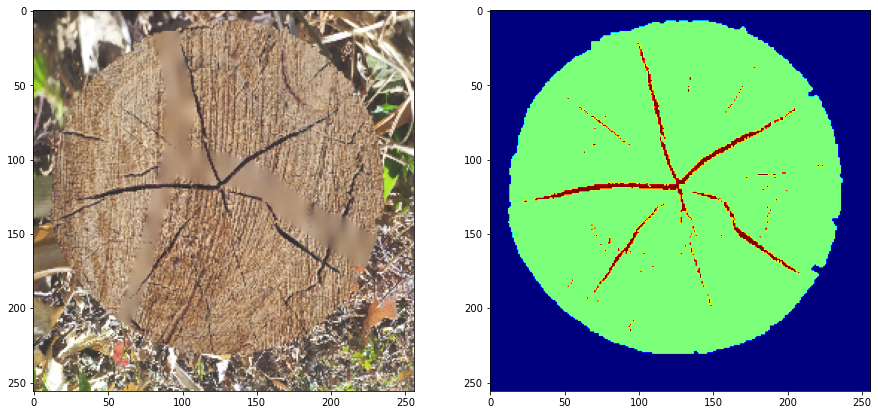

In [ ]:
i = np.random.randint(0, 1000)

fig,ax = plt.subplots(nrows=1 ,ncols=2,figsize=(15,10))
ax[0].imshow(cv2.cvtColor(train_img_aug[i],cv2.COLOR_BGR2RGB))
ax[1].imshow(train_mask_aug[i].reshape(256,256),cmap='jet')


In [ ]:
image_padded.shape

(2, 256, 256, 3)

In [ ]:
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 18
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(8, 8))

        ax[0].imshow(image)
        ax[1].imshow(mask)
    else:
        f, ax = plt.subplots(2, 2, figsize=(8, 8))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)
        
        ax[1, 0].imshow(original_mask)
        ax[1, 0].set_title('Original mask', fontsize=fontsize)
        
        ax[0, 1].imshow(image)
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)
        
        ax[1, 1].imshow(mask)
        ax[1, 1].set_title('Transformed mask', fontsize=fontsize)

In [ ]:


#If starting with pre-trained weights. 
#model.load_weights('???.hdf5')

history = model.fit(X_train, y_train_cat, 
                    batch_size = 8, 
                    verbose=1, 
                    epochs=50, 
                    validation_data=(X_test, y_test_cat), 
                    #class_weight=class_weights,
                    shuffle=True,
                    callbacks=[cp_callback])

Epoch 1/50
27/80 [=========>....................] - ETA: 4:37 - loss: 2.0952 - mean_io_u: 0.3333 - accuracy: 0.3455

4/4 [==============================] - 1s 123ms/step - loss: 0.2012 - mean_io_u: 0.4829 - accuracy: 0.9587
Accuracy is =  95.87458968162537 %


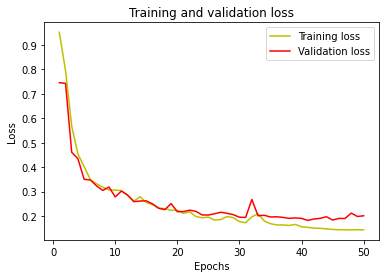

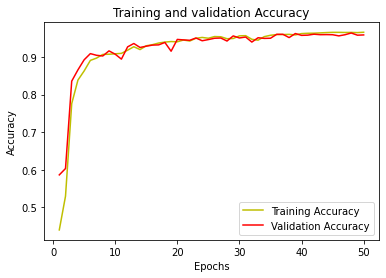

In [ ]:
#Evaluate the model
	# evaluate model
_, iou,acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")


###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

Mean IoU = 0.738945
[[5.031531e+06 1.023630e+05 5.849000e+03 0.000000e+00]
 [6.146200e+04 2.461584e+06 1.547070e+05 0.000000e+00]
 [7.190000e+02 1.127800e+04 1.003630e+05 0.000000e+00]
 [0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]]
IoU for class1 is:  0.9672442
IoU for class2 is:  0.88184756
IoU for class3 is:  0.3677432


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in float_scalars
  from ipykernel import kernelapp as app


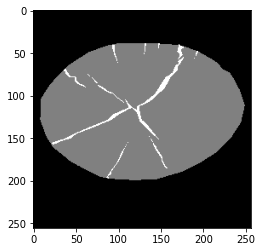

In [ ]:

#Using built in keras function
from keras.metrics import MeanIoU
n_classes =4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)

plt.imshow(train_images_campo[0, :,:,0], cmap='gray')
plt.imshow(train_masks_campo[0], cmap='gray')

In [19]:
SIZE_Y, SIZE_X = 256,256

img_test = cv2.imread('/content/drive/MyDrive/Projetos/Rachadura_Eucalipto/Analise rachadura/CNN//Syntetic_images//Images//SYNT_53.png')
img_test = cv2.resize(img_test, (SIZE_Y, SIZE_X))
img_test1 = tf.keras.utils.normalize(img_test, axis=1)
img_test1 = np.expand_dims(img_test1, axis=0)
prediction = (model.predict(img_test1))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


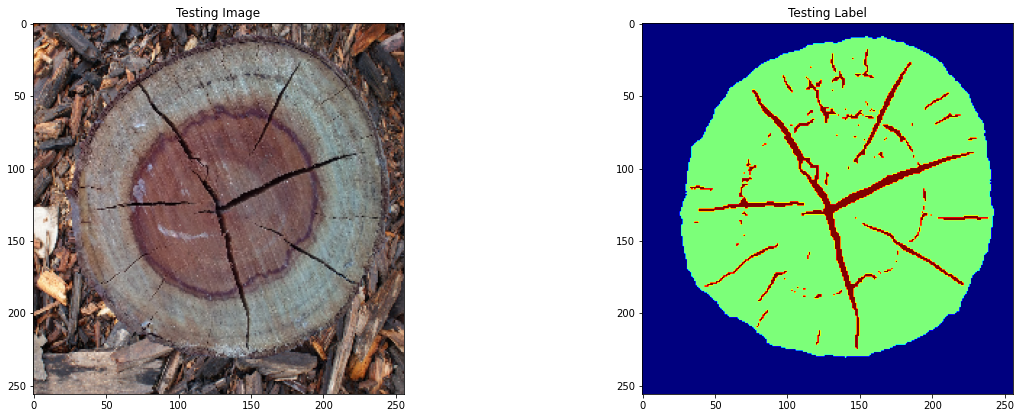

In [20]:
plt.figure(figsize=(20, 15))
plt.subplot(221)
plt.title('Testing Image')
plt.imshow(cv2.cvtColor(img_test,cv2.COLOR_BGR2RGB))
plt.subplot(222)
plt.title('Testing Label')
plt.imshow(predicted_img, cmap='jet')

In [ ]:
tora = len(predicted_img[predicted_img == 1])
racha = len(predicted_img[predicted_img == 2])
racha/tora *100

26.517551641110128

(1, 256, 256, 3)


NameError: ignored

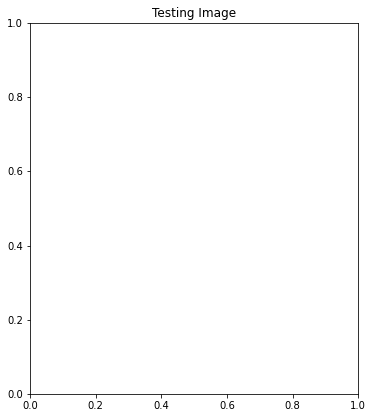

In [ ]:
import random


test_img_number = random.randint(0, (len(X_test)-1))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(20, 15))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(cv2.cvtColor(train_images_campo[indice_test[test_img_number]],cv2.COLOR_BGR2RGB))
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()

In [14]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Projetos/Rachadura_Eucalipto/Analise rachadura/CNN/model/model_312t_8b_100ep_256.h5',custom_objects={'loss':loss})

In [ ]:
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [ ]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
x_train = preprocess_input(X_train)
x_val = preprocess_input(X_test)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
model = sm.Unet(BACKBONE,classes=3, activation='softmax')

dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.5, 1, 20])) 
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics

model.compile(
    'Adam',
    loss=total_loss,
    metrics=[metrics],
)

# fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
model.fit(
   x=x_train,
   y=y_train_cat,
   batch_size=32,
   epochs=50,
   validation_data=(x_val, y_test_cat))